<a href="https://colab.research.google.com/github/NidentalEgor/DigitRecognizerKaggle/blob/master/digit_recognizer_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from keras.datasets import mnist
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
def read_dataset():
  #(X_train, y_train), (X_test, y_test) = mnist.load_data()
  #print("downloaded")
  #return X_train, y_train, X_test

  train_data_file = F"/content/gdrive/My Drive/Colab Notebooks/DigitRecognizerKaggle/Input/train.csv"
  test_data_file = F"/content/gdrive/My Drive/Colab Notebooks/DigitRecognizerKaggle/Input/test.csv"
  print("loaded")

  train_data = pd.read_csv(train_data_file)
  test_data = pd.read_csv(test_data_file)

  Y_train = train_data.iloc[:,0].to_numpy()
  X_train = train_data.iloc[:,1:].to_numpy()
  print(Y_train.shape)
  print(X_train.shape)
  #print(Y_train[:5])
  #print(X_train[:5])

  X_test = test_data.to_numpy()
  
  return X_train, Y_train, X_test

In [0]:
def create_model(show_summary = False):
  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=(28,28,1),padding="same"),
    tf.keras.layers.MaxPool2D(strides=2),
    
    
    tf.keras.layers.Conv2D(128, 3, activation='relu',padding="same"),
    tf.keras.layers.MaxPool2D(strides=2),
    
    tf.keras.layers.Dropout(0.2),
        
    tf.keras.layers.Conv2D(256, 3, activation='relu',padding="same"),
    tf.keras.layers.MaxPool2D(strides=2),
    
    tf.keras.layers.Conv2D(256, 3, activation='relu',padding="same"),
    tf.keras.layers.MaxPool2D(strides=2),
        
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'),
    
    tf.keras.layers.Dense(50,kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'),
        
    tf.keras.layers.Dense(10, kernel_regularizer=tf.keras.regularizers.l2(0.01) ,activation='softmax')
])

  if(show_summary == True):
    model.summary()

  return model

In [0]:
def show_plot(result):
  plt.plot(result.history['accuracy'], label='train')
  plt.plot(result.history['val_accuracy'], label='valid')
  plt.legend(loc='upper left')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.show()
  plt.plot(result.history['loss'], label='train')
  plt.plot(result.history['val_loss'], label='test')
  plt.legend(loc='upper right')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.show()

In [0]:
def train_model(model, X_train, Y_train, batch_size, epoch_number):
  X_t = X_train.reshape(-1,28,28,1)
  print(X_train.shape, X_t.shape)
  Y_t = tf.keras.utils.to_categorical(Y_train.reshape(-1,1))

  model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  result = model.fit(x=X_t,y=Y_t,batch_size=batch_size,epochs=epoch_number,
                     verbose=1,shuffle=False,initial_epoch=0, validation_split=0.2)
  show_plot(result)
  return model

In [0]:
def predict_and_save_result(model, X_test):
  X_t = X_test.reshape(-1,28,28,1)
  test_labels = np.argmax(model.predict(X_t), axis=-1)
  arr = [x for x in range(1,len(test_labels)+1)]
  label = pd.DataFrame(arr,columns = ["ImageId"])
  label["Label"] = pd.DataFrame(test_labels)
  result_file_path = F"/content/gdrive/My Drive/Colab Notebooks/DigitRecognizerKaggle/Result/result_3.csv"
  label.to_csv(result_file_path,header=True,index = False)

loaded
(42000,)
(42000, 784)
(42000, 784) (42000, 28, 28, 1)
Epoch 1/20
5/5 [==============================] - 3s 603ms/step - loss: 22.2581 - accuracy: 0.0989 - val_loss: 7.5738 - val_accuracy: 0.0962
Epoch 2/20
5/5 [==============================] - 3s 578ms/step - loss: 5.9570 - accuracy: 0.1177 - val_loss: 4.2683 - val_accuracy: 0.3790
Epoch 3/20
5/5 [==============================] - 3s 576ms/step - loss: 4.1519 - accuracy: 0.3594 - val_loss: 3.8881 - val_accuracy: 0.5149
Epoch 4/20
5/5 [==============================] - 3s 574ms/step - loss: 3.7723 - accuracy: 0.5328 - val_loss: 3.4975 - val_accuracy: 0.6618
Epoch 5/20
5/5 [==============================] - 3s 573ms/step - loss: 3.5386 - accuracy: 0.5384 - val_loss: 3.1484 - val_accuracy: 0.7199
Epoch 6/20
5/5 [==============================] - 3s 598ms/step - loss: 3.1961 - accuracy: 0.6554 - val_loss: 3.0988 - val_accuracy: 0.6589
Epoch 7/20
5/5 [==============================] - 3s 574ms/step - loss: 2.9494 - accuracy: 0.7136 

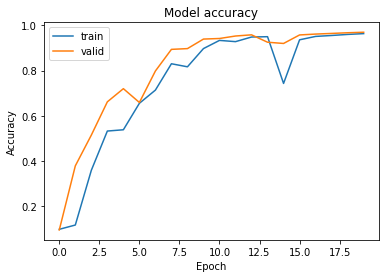

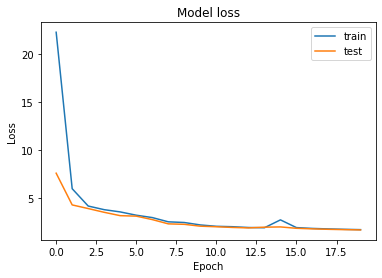

In [11]:
X_train, Y_train, X_test = read_dataset()
model = create_model()
model = train_model(model, X_train, Y_train, 8192, 20)
predict_and_save_result(model, X_test)